In [1]:
from pyhive import hive
import pandas as pd

conn = hive.Connection(
    host="127.0.0.1",   
    port=10000,         
    username="vagrant", 
    database="gold"     
)

df = pd.read_sql("""
    SELECT
        station_id,
        station_name,
        area_id,
        lat,
        lon,
        events_ts,
        dt,
        hour,
        bikes_available,
        slots_available,
        occupancy_ratio,
        temperature_avg,
        wind_speed_avg,
        precipitation_sum,
        trips_count,
        avg_delay_minutes,
        canceled_trips_count,
        gold_ingestion_ts
    FROM gold.bike_weather_bvg_features
""", conn)


df.head()


C:\Users\Laptop\AppData\Local\Temp\ipykernel_24340\1993937410.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,station_id,station_name,area_id,lat,lon,events_ts,dt,hour,bikes_available,slots_available,occupancy_ratio,temperature_avg,wind_speed_avg,precipitation_sum,trips_count,avg_delay_minutes,canceled_trips_count,gold_ingestion_ts
0,6302621,6302621,unknown_area,None,None,2026-01-14 09:30:48,2026-01-14,9,0,8,0.00,4.47,5.36,1.5,17369.0,-0.0038,0.0,2026-01-14 23:05:21.311
1,25115748,25115748,unknown_area,None,None,2026-01-14 09:30:48,2026-01-14,9,2,3,0.40,4.47,5.36,1.5,17369.0,-0.0038,0.0,2026-01-14 23:05:21.311
2,27915279,27915279,unknown_area,None,None,2026-01-14 09:30:48,2026-01-14,9,0,4,0.00,4.47,5.36,1.5,17369.0,-0.0038,0.0,2026-01-14 23:05:21.311
3,121187464,121187464,unknown_area,None,None,2026-01-14 09:30:48,2026-01-14,9,0,4,0.00,4.47,5.36,1.5,17369.0,-0.0038,0.0,2026-01-14 23:05:21.311
4,131505907,131505907,unknown_area,None,None,2026-01-14 09:30:48,2026-01-14,9,1,3,0.25,4.47,5.36,1.5,17369.0,-0.0038,0.0,2026-01-14 23:05:21.311


In [2]:
print(df.shape)
print(df['dt'].value_counts())
print(df['hour'].value_counts())
print(df[['temperature_avg','trips_count']].isna().mean())

(18675, 18)
dt
2026-01-14    18675
Name: count, dtype: int64
hour
20    10375
21     4150
10     2075
9      2075
Name: count, dtype: int64
temperature_avg    0.222222
trips_count        0.777778
dtype: float64


In [3]:
import matplotlib.pyplot as plt

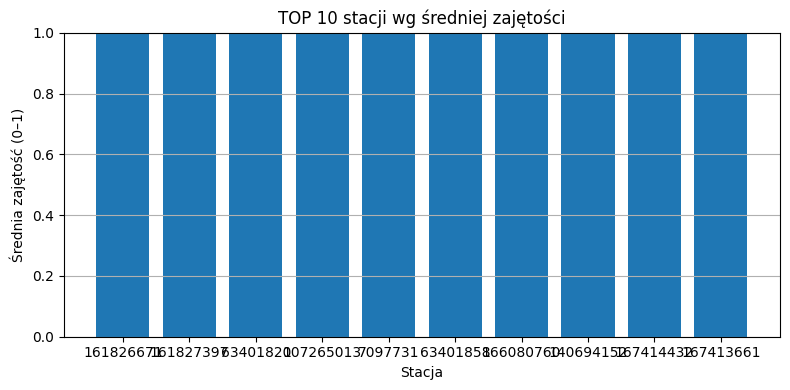

In [4]:
station_rank = (
    df.groupby(["station_id", "station_name"], as_index=False)
      .agg(
          avg_occupancy=("occupancy_ratio", "mean"),
          avg_bikes=("bikes_available", "mean"),
          avg_slots=("slots_available", "mean"),
      )
      .sort_values("avg_occupancy", ascending=False)
)

top_n = 10
top = station_rank.head(top_n)

plt.figure(figsize=(8, 4))
plt.bar(top["station_id"].astype(str), top["avg_occupancy"])
plt.xlabel("Stacja")
plt.ylabel("Średnia zajętość (0–1)")
plt.title(f"TOP {top_n} stacji wg średniej zajętości")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [5]:
station_rank = (
    df.groupby(["station_id", "station_name"], as_index=False)
      .agg(
          avg_occupancy=("occupancy_ratio", "mean"),
          avg_bikes_available=("bikes_available", "mean"),
          avg_slots_available=("slots_available", "mean")
      )
      .sort_values("avg_occupancy", ascending=False)
)

station_rank = station_rank.rename(columns={"avg_occupancy": "avg_rentals_per_hour"})

print("\nTOP 10 stacji wg średniej zajętości:")
print(station_rank.head(10))


TOP 10 stacji wg średniej zajętości:
     station_id station_name  avg_rentals_per_hour  avg_bikes_available  \
770   161826671    161826671                   1.0             4.000000   
771   161827397    161827397                   1.0             4.000000   
2023   63401820     63401820                   1.0             6.222222   
46    107265013    107265013                   1.0            10.888889   
2034    7097731      7097731                   1.0             8.777778   
2024   63401858     63401858                   1.0             4.000000   
886   166080760    166080760                   1.0             4.222222   
698   140694152    140694152                   1.0             8.111111   
912   167414432    167414432                   1.0             8.222222   
911   167413661    167413661                   1.0             7.777778   

      avg_slots_available  
770                   0.0  
771                   0.0  
2023                  0.0  
46                    0.

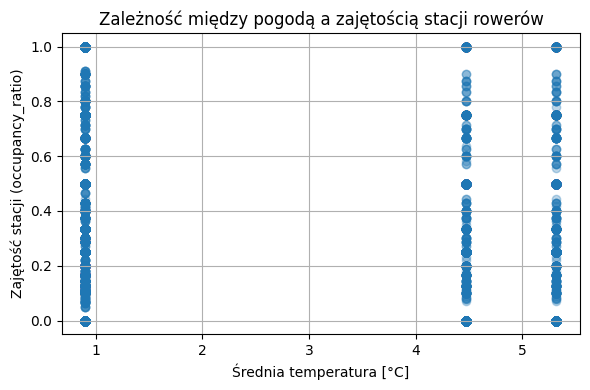

In [6]:
temp_occ = df.dropna(subset=["occupancy_ratio", "temperature_avg"])

plt.figure(figsize=(6, 4))
plt.scatter(temp_occ["temperature_avg"], temp_occ["occupancy_ratio"], alpha=0.3)
plt.xlabel("Średnia temperatura [°C]")
plt.ylabel("Zajętość stacji (occupancy_ratio)")
plt.title("Zależność między pogodą a zajętością stacji rowerów")
plt.grid(True)
plt.tight_layout()
plt.show()


Profil dobowy – średnia zajętość i liczba kursów BVG wg godziny:
   hour  avg_occupancy  avg_trips
0     9       0.200931    17369.0
1    10       0.200657    14135.0
2    20       0.203849        NaN
3    21       0.204029        NaN


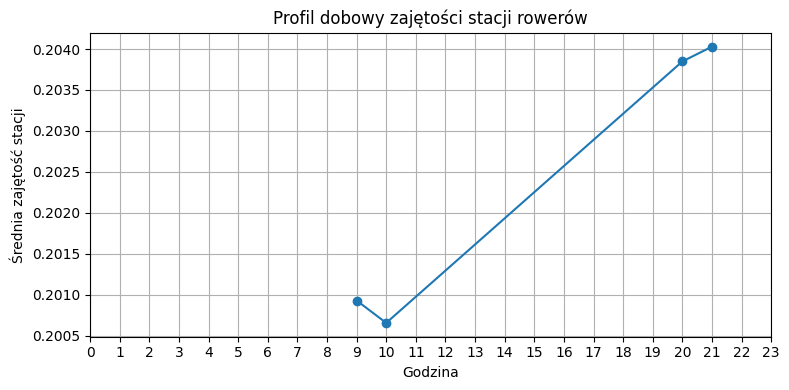

In [7]:
hourly_profile = (
    df.groupby("hour", as_index=False)
      .agg(
          avg_occupancy=("occupancy_ratio", "mean"),
          avg_trips=("trips_count", "mean"),
      )
      .sort_values("hour")
)

print("\nProfil dobowy – średnia zajętość i liczba kursów BVG wg godziny:")
print(hourly_profile)

plt.figure(figsize=(8, 4))
plt.plot(hourly_profile["hour"], hourly_profile["avg_occupancy"], marker="o")
plt.xlabel("Godzina")
plt.ylabel("Średnia zajętość stacji")
plt.title("Profil dobowy zajętości stacji rowerów")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

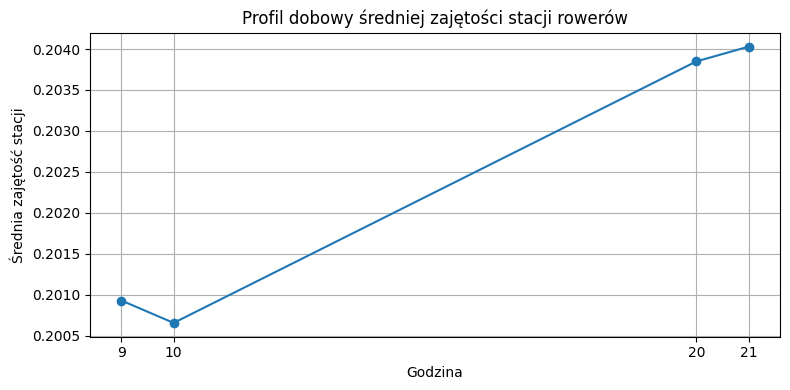

In [8]:
hourly_profile = (
    df.groupby("hour", as_index=False)
      .agg(
          avg_occupancy=("occupancy_ratio", "mean"),
      )
      .sort_values("hour")
)

plt.figure(figsize=(8, 4))
plt.plot(hourly_profile["hour"], hourly_profile["avg_occupancy"], marker="o")
plt.xlabel("Godzina")
plt.ylabel("Średnia zajętość stacji")
plt.title("Profil dobowy średniej zajętości stacji rowerów")
plt.xticks(hourly_profile["hour"])
plt.grid(True)
plt.tight_layout()
plt.show()


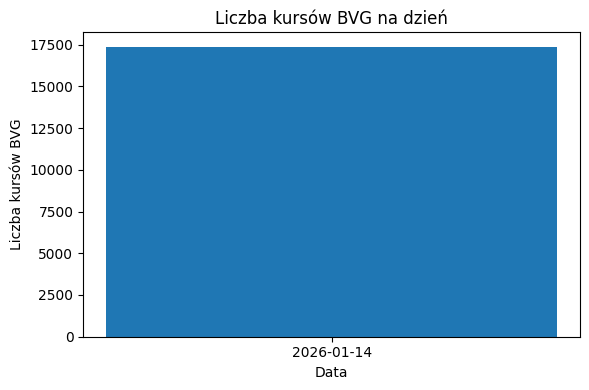

In [9]:
bvg_daily = (
    df[["dt", "trips_count"]]
      .dropna()
      .drop_duplicates()
      .sort_values("dt")
)

plt.figure(figsize=(6, 4))
plt.bar(bvg_daily["dt"].astype(str), bvg_daily["trips_count"])
plt.xlabel("Data")
plt.ylabel("Liczba kursów BVG")
plt.title("Liczba kursów BVG na dzień")
plt.tight_layout()
plt.show()


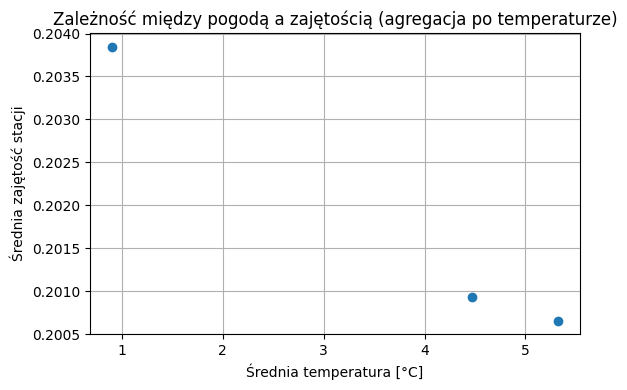

In [10]:
temp_agg = (
    df.dropna(subset=["occupancy_ratio", "temperature_avg"])
      .groupby("temperature_avg", as_index=False)
      .agg(
          avg_occupancy=("occupancy_ratio", "mean")
      )
)

plt.figure(figsize=(6, 4))
plt.scatter(temp_agg["temperature_avg"], temp_agg["avg_occupancy"])
plt.xlabel("Średnia temperatura [°C]")
plt.ylabel("Średnia zajętość stacji")
plt.title("Zależność między pogodą a zajętością (agregacja po temperaturze)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
df["hour_of_day"] = df["hour_start"].dt.hour
df["dt"] = pd.to_datetime(df["dt"], errors="coerce", infer_datetime_format=True)
df["day_of_week"] = df["dt"].dt.dayofweek  # 0 = poniedziałek


KeyError: 'hour_start'

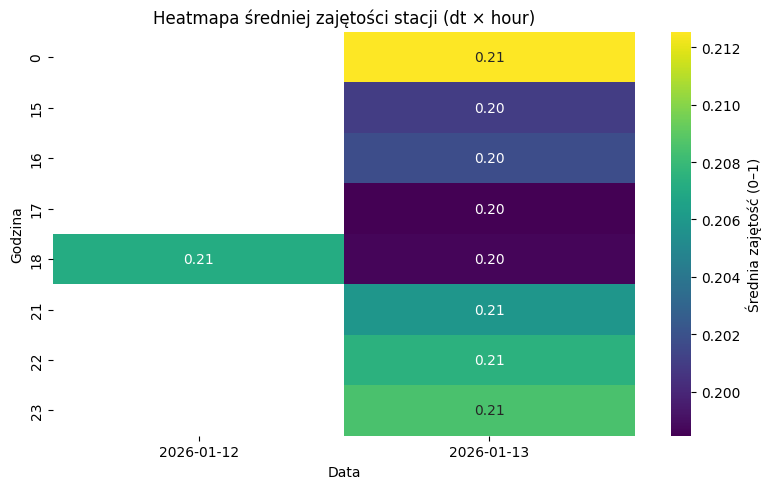

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

heat = (
    df.groupby(["dt", "hour"])["occupancy_ratio"]
      .mean()
      .reset_index()
      .pivot(index="hour", columns="dt", values="occupancy_ratio")
      .sort_index()
)

plt.figure(figsize=(8, 5))
sns.heatmap(
    heat,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "Średnia zajętość (0–1)"}
)
plt.xlabel("Data")
plt.ylabel("Godzina")
plt.title("Heatmapa średniej zajętości stacji (dt × hour)")
plt.tight_layout()
plt.show()


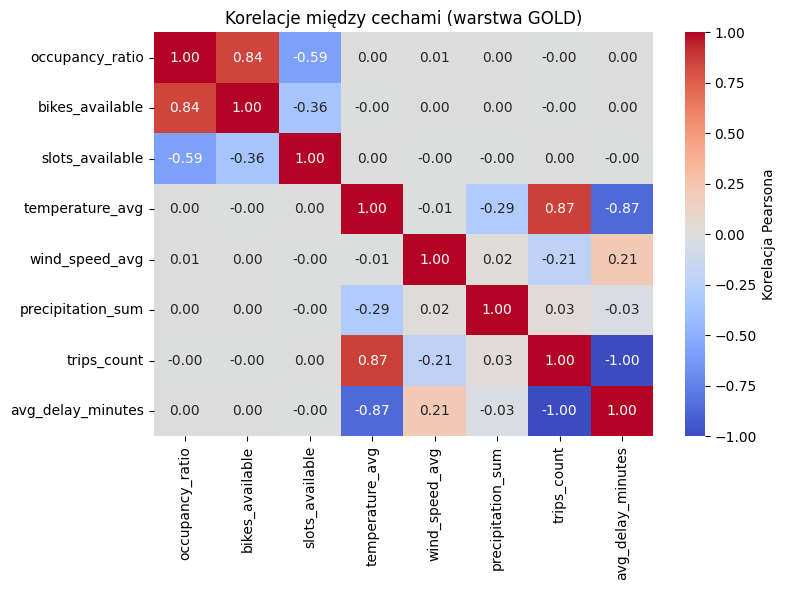

In [ ]:
num_cols = [
    "occupancy_ratio",
    "bikes_available",
    "slots_available",
    "temperature_avg",
    "wind_speed_avg",
    "precipitation_sum",
    "trips_count",
    "avg_delay_minutes",
]

corr = df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Korelacja Pearsona"}
)
plt.title("Korelacje między cechami (warstwa GOLD)")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def radar_for_station(df, station_id):
    metrics = ["occupancy_ratio", "bikes_available", "slots_available", "trips_count"]
    labels = ["Śr. zajętość", "Śr. rowery", "Śr. sloty", "Śr. kursy BVG"]

    agg = df.groupby("station_id")[metrics].mean()

    if station_id not in agg.index:
        raise ValueError(f"Brak stacji {station_id} w danych.")

    station_vals = agg.loc[station_id]
    mins = agg.min()
    maxs = agg.max()
    denom = (maxs - mins).replace(0, 1)
    norm_vals = ((station_vals - mins) / denom).values

    values = np.concatenate([norm_vals, [norm_vals[0]]])
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
    angles = np.concatenate([angles, [angles[0]]])

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values, "o-")
    ax.fill(angles, values, alpha=0.25)

    ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels)
    ax.set_ylim(0, 1)

    title_name = df.loc[df["station_id"] == station_id, "station_name"].iloc[0]
    ax.set_title(f"Profil stacji {station_id} ({title_name}) – wartości znormalizowane", pad=20)
    plt.tight_layout()
    plt.show()


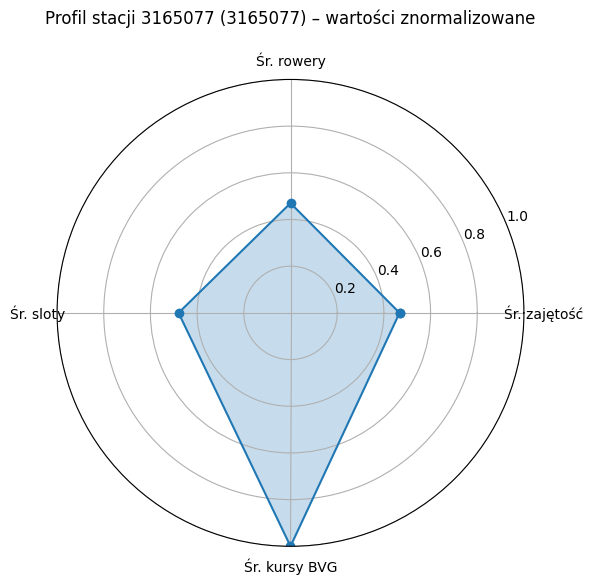

In [ ]:
radar_for_station(df, station_id="3165077")  

In [ ]:
print(df[["lat", "lon"]].isna().mean())

lat    1.0
lon    1.0
dtype: float64


           dt  avg_occupancy  trips_count
0  2026-01-12       0.207101     253050.0
1  2026-01-13       0.203632    1235937.0


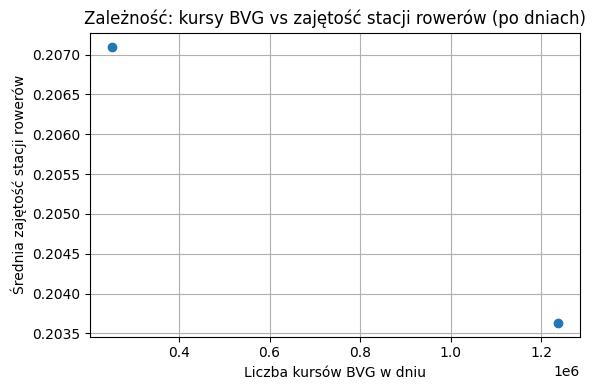

In [ ]:
import matplotlib.pyplot as plt

daily = (
    df.groupby("dt", as_index=False)
      .agg(
          avg_occupancy=("occupancy_ratio", "mean"),
          trips_count=("trips_count", "mean")  # mean == max, bo stała w ramach dnia
      )
      .dropna(subset=["trips_count"])
      .sort_values("dt")
)

print(daily)

plt.figure(figsize=(6, 4))
plt.scatter(daily["trips_count"], daily["avg_occupancy"])
plt.xlabel("Liczba kursów BVG w dniu")
plt.ylabel("Średnia zajętość stacji rowerów")
plt.title("Zależność: kursy BVG vs zajętość stacji rowerów (po dniach)")
plt.grid(True)
plt.tight_layout()
plt.show()


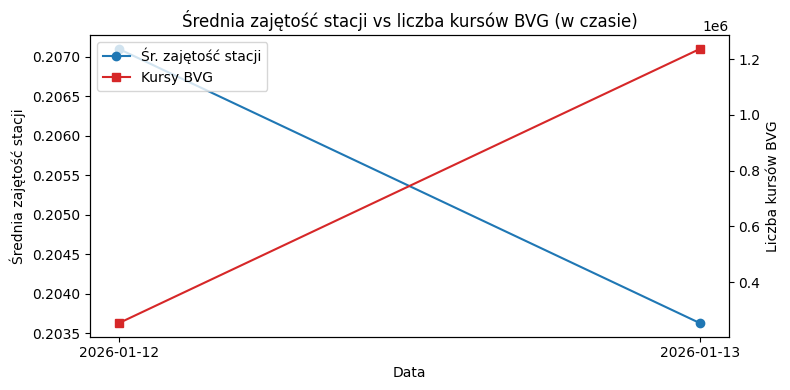

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(daily["dt"], daily["avg_occupancy"], marker="o", label="Śr. zajętość stacji")
ax1.set_xlabel("Data")
ax1.set_ylabel("Średnia zajętość stacji")
ax1.tick_params(axis="y")

ax2 = ax1.twinx()
ax2.plot(daily["dt"], daily["trips_count"], color="tab:red", marker="s", label="Kursy BVG")
ax2.set_ylabel("Liczba kursów BVG")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Średnia zajętość stacji vs liczba kursów BVG (w czasie)")
fig.tight_layout()
plt.show()


In [ ]:
import folium

snapshot = df[(df["dt"] == df["dt"].min()) & (df["hour"] == df["hour"].max())]
snapshot = snapshot.dropna(subset=["lat", "lon"])

center_lat = snapshot["lat"].mean()
center_lon = snapshot["lon"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

for _, row in snapshot.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=5,
        fill=True,
        fill_opacity=0.8,
        popup=f"{row['station_id']} – occ={row['occupancy_ratio']:.2f}",
    ).add_to(m)

m


ValueError: Location values cannot contain NaNs.